<p align="center">
  <img src="img/image_principal.jpg" width="1000" title="img-principal">
</p>

# 1.0 CONTEXTO DO PROBLEMA

O CFO da empresa fez uma reunião com todos os Gerentes de Loja e pediu para que cada um deles trouxessem uma previsão das próximas 6 semanas de vendas.

# 2.0 ENTENDIMENTO DO PROBLEMA

**Motivação:**
  - A previsão de vendas foi requisitada pelo CFO em uma reunião mensal sobre os resultados das lojas.
   
**Causa do Raiz do Problema:**
   - Dificuldade em determinar o valor do investimento para Reformas de cada Loja.
    
**Quem é o Stakeholder:**
   - Diretor Financeiro (CFO) da Rossmann.
    
**Formato da Solução:**
   - **Granularidade:** Previsão de vendas por Dia da Loja pra os próximos 42 dias, 6 semanas.
   - **Tupo de Problema:** Previsão de Vendas.
   - **Potênciais Métodos:** Séries Temporais, Regressão.
   - **Formato da Entrega:** O valor das Vendas no final de cada 6º semana. E acesso as vendas através do Celular.

# 3.0 COLETA DE DADOS

## 3.1 Importações

In [53]:
# Manipulation and math
import pandas as pd
import numpy as np
import inflection
import datetime
from scipy import stats
import random

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Machine Learning
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from sklearn.linear_model import LinearRegression, Lasso
import xgboost as xgb

# Metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

## 3.2 Funções Auxiliares

In [2]:
# correlation categories
def cramer_v(x, y):
    
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2_corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    
    kcorr = k - (k-1) **2 / (n-1)
    rcorr = r - (r-1) **2 / (n-1)
    
    return np.sqrt((chi2_corr / n) / (min(kcorr-1, rcorr-1)))


# Show matrix correlation
def show_matrix(col, data, output='list'):

    rows = []
    index = []
    columns = []

    for c in data.columns:

        result = cramer_v(x=data[str(col)], y=data[str(c)])

        rows.append(result)
        index.append(str(c))
        columns.append(str(col))
        
    if output == 'list':
        return rows
    
    elif output == 'dict':
        return pd.DataFrame(rows, index=index, columns=[str(col)])
    
    
def ml_error(model_name, y, yhat):
    
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])


def cross_validation(x_training, kfold, model_name, model, verbose=False):

    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold+1)):
        
        if verbose:
            print('KFold Number:', k)
            
        # Start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*7)

        # Filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # Training 
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # Validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # Model
        m = model.fit(xtraining, ytraining)

        # Prediction
        yhat = m.predict(xvalidation)

        # Performance
        m_result = ml_error(str(model_name), np.expm1(yvalidation), np.expm1(yhat))

        # Store performance of each KFold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    dataframe = pd.DataFrame(
        {'Model Name': model_name,
         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0]
    )
    
    return dataframe

## 3.3 Carregamento de Dados

In [3]:
df_sales = pd.read_csv('data/train.csv', low_memory=False)
df_store = pd.read_csv('data/store.csv', low_memory=False)

# merge data
df_raw = pd.merge(df_sales, df_store, how='left', on='Store')

df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 4.0 DESCRIÇÃO DE DADOS

## 4.1 Dimensão de Dados

In [4]:
row = df_raw.shape[0]
col = df_raw.shape[1]

print(f'Número de Linhas: {row}')
print(f'Número de Colunas: {col}')

Número de Linhas: 1017209
Número de Colunas: 18


## 4.2 Tipo de Dados

In [5]:
df_raw['Date'] = pd.to_datetime(df_raw['Date'])
df_raw.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
dtype: object

## 4.3 Verificação de Dados Faltantes

In [6]:
df_raw.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

## 4.4 Limpeza de Dados

### 4.4.1 Renomeação de Colunas

In [7]:
cols_old = list(df_raw.columns)

snakeCase = lambda x: inflection.underscore(x)
cols_new = list(map(snakeCase, cols_old))

df_raw.columns = cols_new
df_raw.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

### 4.4.2 Tratamento de Dados Faltantes

In [8]:
# -- competition_distance
df_raw['competition_distance'] = df_raw['competition_distance'].apply(lambda x: 200000.0 if pd.isnull(x) else x)


# -- competition_open_since_month
df_raw['competition_open_since_month'] = df_raw[['date', 'competition_open_since_month']].apply(lambda x: x['date'].month if pd.isnull(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)


# -- competition_open_since_year 
df_raw['competition_open_since_year'] = df_raw[['date', 'competition_open_since_year']].apply(lambda x: x['date'].year if pd.isnull(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)


# -- promo2_since_week
df_raw['promo2_since_week'] = df_raw[['date', 'promo2_since_week']].apply(lambda x: x['date'].week if pd.isnull(x['promo2_since_week']) else x['promo2_since_week'], axis=1)


# -- promo2_since_year  
df_raw['promo2_since_year'] = df_raw[['date', 'promo2_since_year']].apply(lambda x: x['date'].year if pd.isnull(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


# -- promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df_raw['promo_interval'].fillna(0, inplace=True)
df_raw['month_map'] = df_raw['date'].dt.month.map(month_map)

df_raw['is_promo'] = df_raw[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


# Show NaN
df_raw.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### 4.4.3 Mudança de Tipo nos Dados

In [9]:
# competition_open_since_month
df_raw['competition_open_since_month'] = df_raw['competition_open_since_month'].astype('int64')


# competition_open_since_year
df_raw['competition_open_since_year'] = df_raw['competition_open_since_year'].astype('int64')


#cpromo2_since_week
df_raw['promo2_since_week'] = df_raw['promo2_since_week'].astype('int64')


# promo2_since_year
df_raw['promo2_since_year'] = df_raw['promo2_since_year'].astype('int64')

## 4.5 Estatistica Descritiva

### 4.5.1 Atributos Numéricos

In [10]:
num_attributes = df_raw.select_dtypes(include=['int64', 'float64'])

describe = num_attributes.describe().T

# Add Kutsosis and Skew
describe['skews'] = num_attributes.apply(lambda x: x.skew()) 
describe['kurtosis'] = num_attributes.apply(lambda x: x.kurtosis()) 

describe

,count,mean,std,min,25%,50%,75%,max,skews,kurtosis
store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0,-0.000955,-1.200524
day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0,0.001593,-1.246873
sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0,0.641460,1.778375
customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0,1.598650,7.091773
open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0,-1.758045,1.090723
promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0,0.487838,-1.762018
school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0,1.677842,0.815154
competition_distance,1017209.0,5935.442677,12547.652996,20.0,710.0,2330.0,6910.0,200000.0,10.242344,147.789712
competition_open_since_month,1017209.0,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0,-0.042076,-1.232607
competition_open_since_year,1017209.0,2010.324840,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0,-7.235657,124.071304


### 4.5.2 Atributos Categóricos

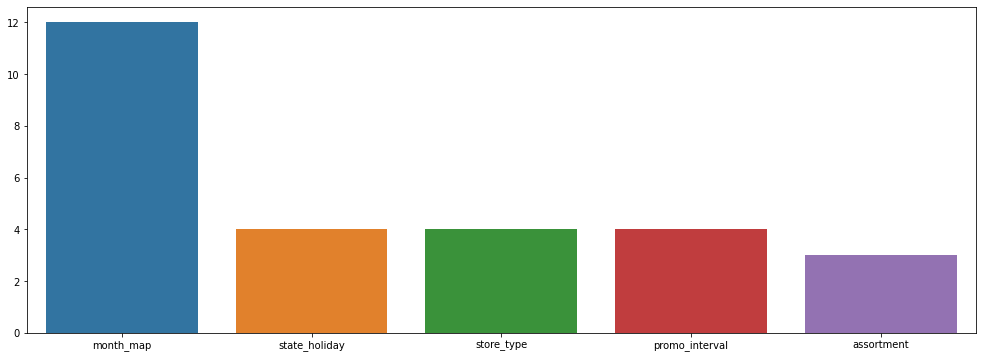

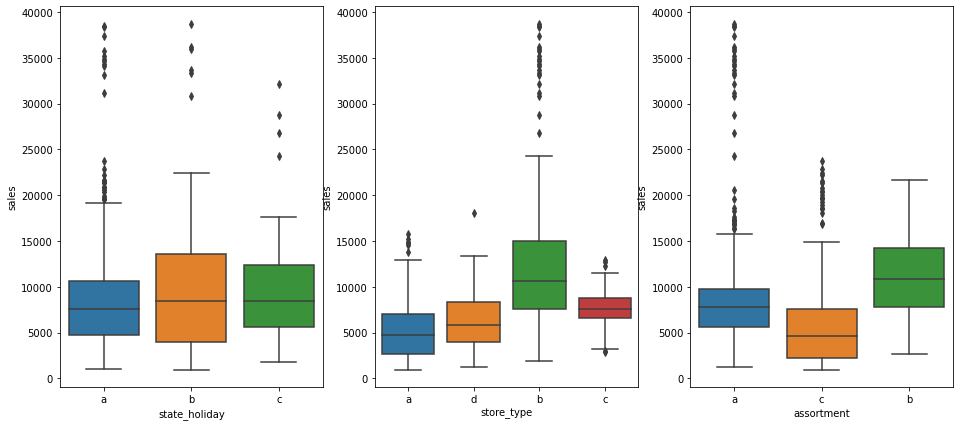

In [11]:
# Filter Categories
cat_attributes = df_raw.select_dtypes(include=['object']) 


# -- Figure 1
unique_values = cat_attributes.apply(lambda x: len(x.unique())).sort_values(ascending=False)
plt.figure(figsize=(17, 6))
sns.barplot(x=unique_values.index, y=unique_values.values)


# -- Figure 2
filter_zero = df_raw[(df_raw['state_holiday'] != '0') & (df_raw['sales'] > 0)]

plt.figure(figsize=(16, 7))
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=filter_zero)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=filter_zero)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=filter_zero);

# 5.0 LVENATAMENTO DE HIPÓTESES

## 5.1 Mapa Mental de Hipóteses

<p align="center">
  <img src="img/mind_map.png" width="1000" title="img-principal">
</p>

## 5.2 Criação de Hipóteses

### 5.2.1  Hipópteses Loja

**1.** Lojas númeuro maior de funcionários vendem mais.

**2.** Lojas com maior capacidade de estoque vendem mais.

**3.** Lojas com maior porte vendem mais.

**4.** Lojas com maior sortimento vendem mais.

**5.** Lojas com competidores mais próximos vendem menos.

**6.** Lojas com competidores à mais tempo vendem mais.

### 5.2.2 Hipóteses Produto

**1.** Lojas que investem mais em Marketing vendem mais.

**2.** Lojas com mais exposição de produtos vendem mais.

**3.** Lojas com menores preços nos produtos vendem mais.

**4.** Lojas com promoções mais agressivas (descontos maiores), vendem mais.

**5.** Lojas com promoções ativas por mais tempo vendem mais.

**6.** Lojas com mais dias de promoção vendem mais.

**7.** Lojas com mais promoções consecutivas vendem mais.

### 5.2.3 Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal vendem mais.

**2.** Lojas vendem mais ao longo dos anos.

**3.** Lojas vendem mais no segundo semestre do ano.

**4.** Lojas vendem mais depois do dia 10 de cada mês.

**5.** Lojas vendem menos aos finais de semana.

**6.** Lojas vendem menos durante os feriados escolares.

## 5.3 Lista Final de Hipóteses

**1.** Lojas com maior sortimento vendem mais.

**2.** Lojas com competidores mais próximos vendem menos.

**3.** Lojas com competidores à mais tempo vendem mais.

**4.** Lojas com promoções ativas por mais tempo vendem mais.

**5.** Lojas com mais dias de promoção vendem mais.

**6.** Lojas com mais promoções consecutivas vendem mais.

**7.** Lojas abertas durante o feriado de Natal vendem mais.

**8.** Lojas vendem mais ao longo dos anos.

**9.** Lojas vendem mais no segundo semestre do ano.

**10.** Lojas vendem mais depois do dia 10 de cada mês.

**11.** Lojas vendem menos aos finais de semana.

**12.** Lojas vendem menos durante os feriados escolares.

# 6.0 FEATURE ENGINEERING

In [12]:
# Year
df_raw['year'] = df_raw['date'].dt.year

# Month
df_raw['month'] = df_raw['date'].dt.month


# Day
df_raw['day'] = df_raw['date'].dt.day


# Week of Year
df_raw['week_of_year'] = df_raw['date'].dt.isocalendar().week


# Year Week
df_raw['year_week'] = df_raw['date'].dt.strftime('%Y-%W')


# Competition since
df_raw['competition_since'] = df_raw.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df_raw['competition_time_month'] = ((df_raw['date'] - df_raw['competition_since']) / 30).apply(lambda x: x.days).astype('int')
                                                                                                            
                                                                                                            
# Promo since
df_raw['promo_since'] = df_raw['promo2_since_year'].astype('str') + '-' + df_raw['promo2_since_week'].astype('str')
df_raw['promo_since'] = df_raw['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df_raw['promo_time_week'] = ((df_raw['date'] - df_raw['promo_since']) / 7).apply(lambda x: x.days).astype('int')


# Assortment
df_raw['assortment'] = df_raw['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
            
                                                                                                            
# State Holiday
df_raw['state_holiday'] = df_raw['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a'  else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 7.0 FILTRAGEM DE VARIÁVEIS

In [13]:
df = df_raw.copy()

## 7.1 Filtragem de Linhas

In [14]:
# Filtering sales > 0
df = df[(df['open'] != 0) & (df['sales'] > 0)]

## 7.2 Filtragem de Colunas

In [15]:
# Drop columns 
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df.drop(columns=cols_drop, inplace=True)

# 8.0 ANÁLISE EXPLORATÓRIA

## 8.1 Análise Univariada

### 8.1.1 Variável Resposta

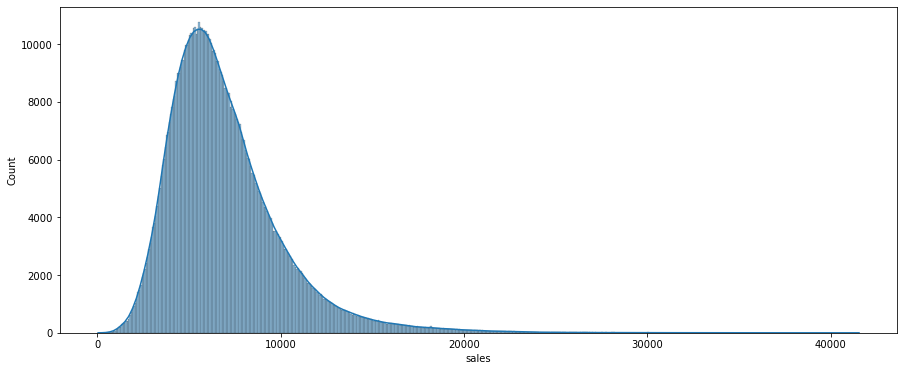

In [16]:
plt.figure(figsize=(15, 6))
sns.histplot(df['sales'], kde=True, );

### 8.1.2 Variável Numérica

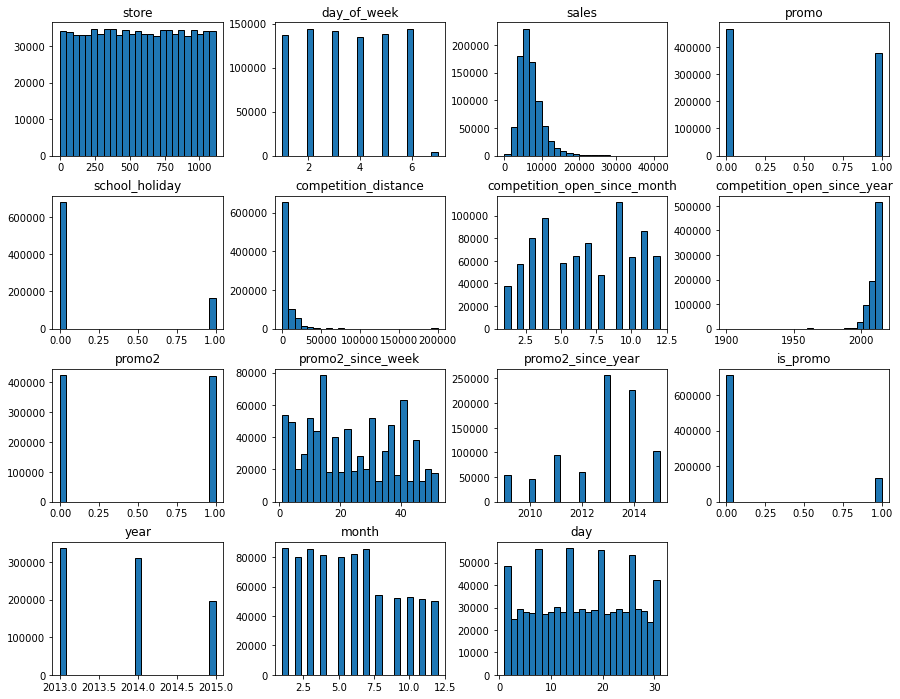

In [17]:
numerical = df.select_dtypes(include=['int64', 'float64'])
numerical.hist(figsize=(15, 12), bins=25, grid=False, ec='k');

### 8.1.3 Variável Categórica

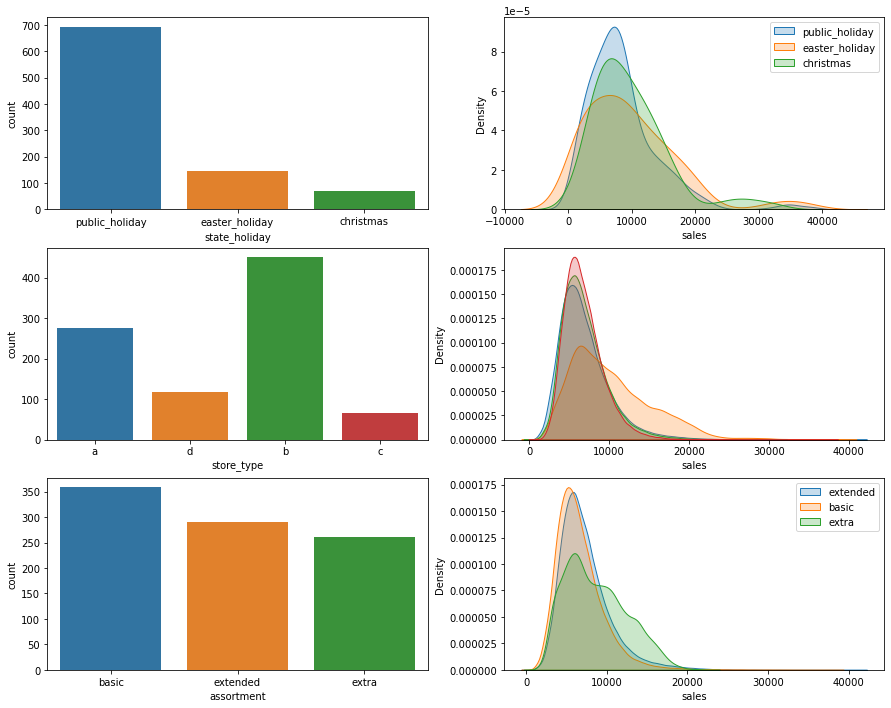

In [18]:
categories = df.select_dtypes(include=['object'])

# -- state_holiday
filter_holiday = categories[categories['state_holiday'] != 'regular_day']
plt.figure(figsize=(15, 12))
plt.subplot(3, 2, 1)
sns.countplot(x='state_holiday', data=filter_holiday)

plt.subplot(3, 2, 2)
sns.kdeplot(x=df[df['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(x=df[df['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(x=df[df['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)
plt.legend()


# -- store_type
plt.subplot(3, 2, 3)
sns.countplot(x='store_type', data=filter_holiday)

plt.subplot(3, 2, 4)
sns.kdeplot(x=df[df['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(x=df[df['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(x=df[df['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(x=df[df['store_type'] == 'd']['sales'], label='d', shade=True)


# -- assortment
plt.subplot(3, 2, 5)
sns.countplot(x='assortment', data=filter_holiday)

plt.subplot(3, 2, 6)
sns.kdeplot(x=df[df['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(x=df[df['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(x=df[df['assortment'] == 'extra']['sales'], label='extra', shade=True)

plt.legend();

## 8.2 Análise Bivariada

### H1. Lojas com maior sortimento vendem mais.

**FALSA** Lojas com maior sortmento vendem menos.

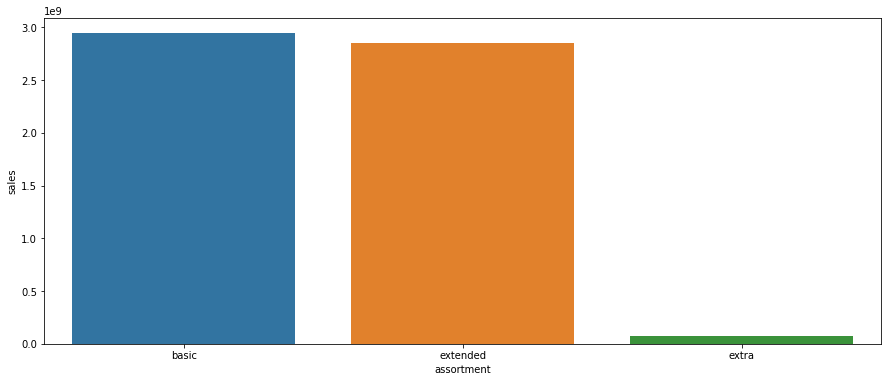

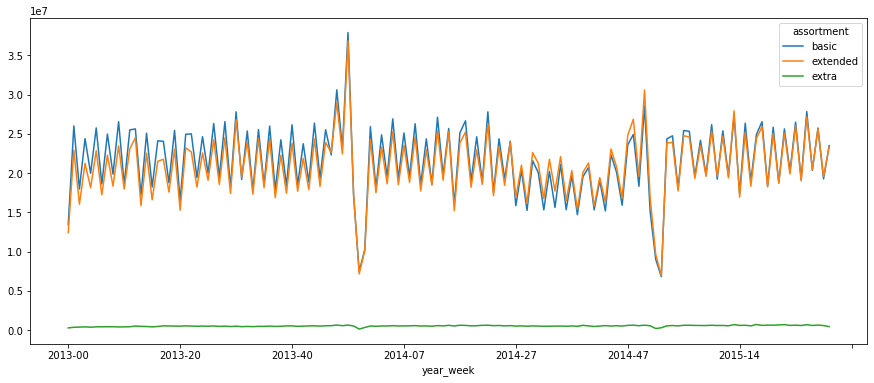

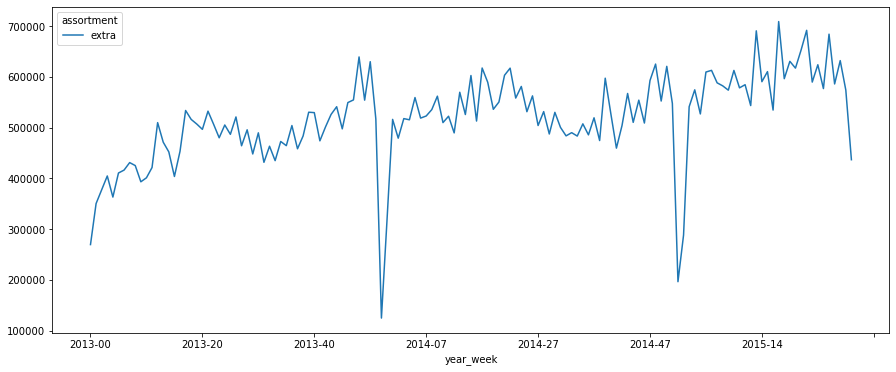

In [19]:
filter_1 = df['sales'].groupby(df['assortment']).sum().reset_index()

plt.figure(figsize=(15, 6))
sns.barplot(x='assortment', y='sales', data=filter_1)

filter_2 = df[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
filter_2.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(15, 6))

filter_3 = filter_2[filter_2['assortment'] == 'extra']
filter_3.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(15, 6));

### H2. Lojas com competidores mais próximos vendem menos.

**FALSA** Lojas com competidores mais próximos vendem mais.

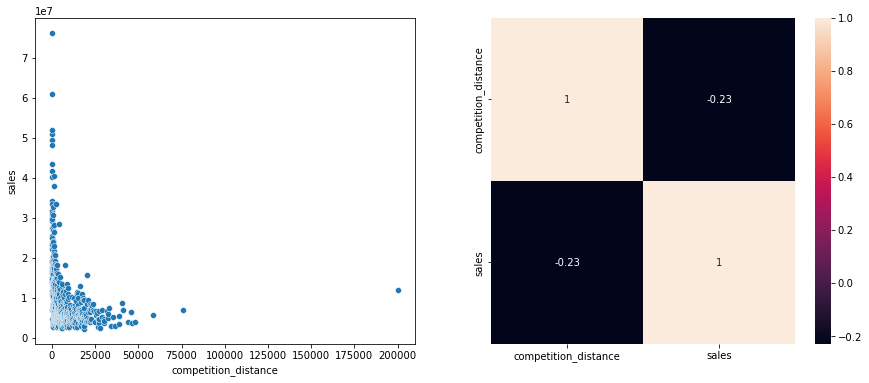

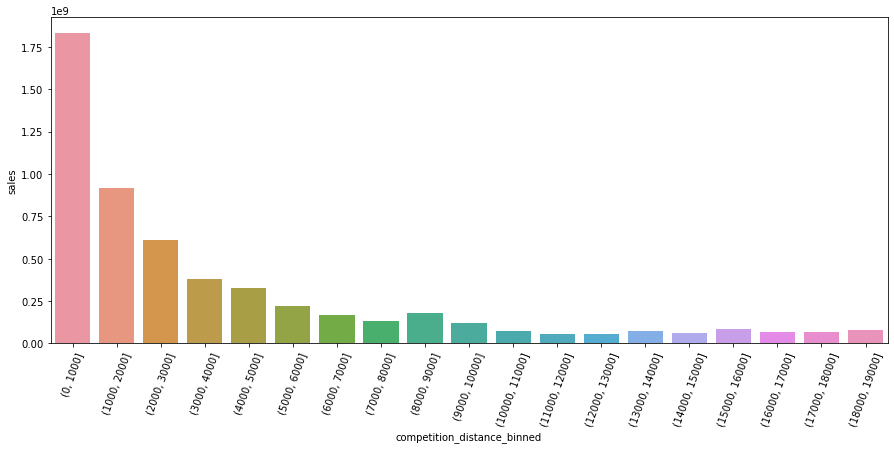

In [20]:
# Figure 1
filter_h1 = df_raw[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x='competition_distance', y='sales', data=filter_h1)


# Figure 2
plt.subplot(1, 2, 2)
sns.heatmap(filter_h1.corr(method='pearson'), annot=True)


# Figure 3
plt.figure(figsize=(15, 6))
bins = list(np.arange(0, 20000, 1000))
filter_h1['competition_distance_binned'] = pd.cut(filter_h1['competition_distance'], bins=bins)
filter_h2 = filter_h1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

sns.barplot(x='competition_distance_binned', y='sales', data=filter_h2)
plt.xticks(rotation=70);

### H3.Lojas com competidores à mais tempo vendem mais.

**FALSA** Lojas com competidores à mais tempo vendem menos.

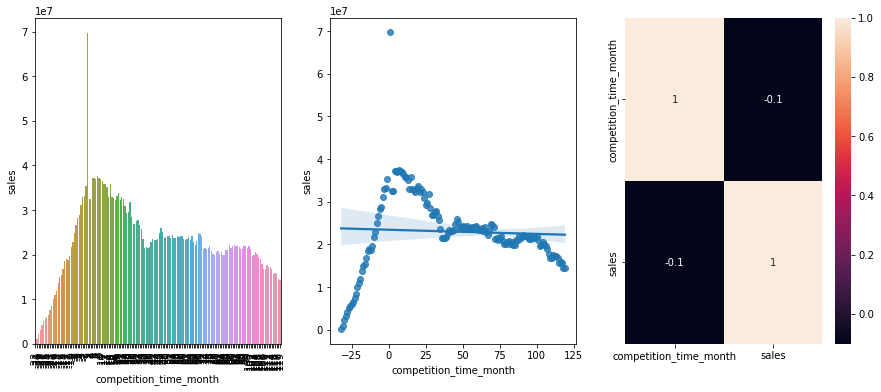

In [21]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
filter_h1 = df[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
filter_h2 = filter_h1[(filter_h1['competition_time_month'] < 120) & (filter_h1['competition_time_month'] != 0)]

sns.barplot(x='competition_time_month', y='sales', data=filter_h2)
plt.xticks(rotation=90)


plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=filter_h2)

plt.subplot(1, 3, 3)
sns.heatmap(filter_h1.corr(method='pearson'), annot=True);

### H4. Lojas com promoções ativas por mais tempo vendem mais

**FALSA** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção.

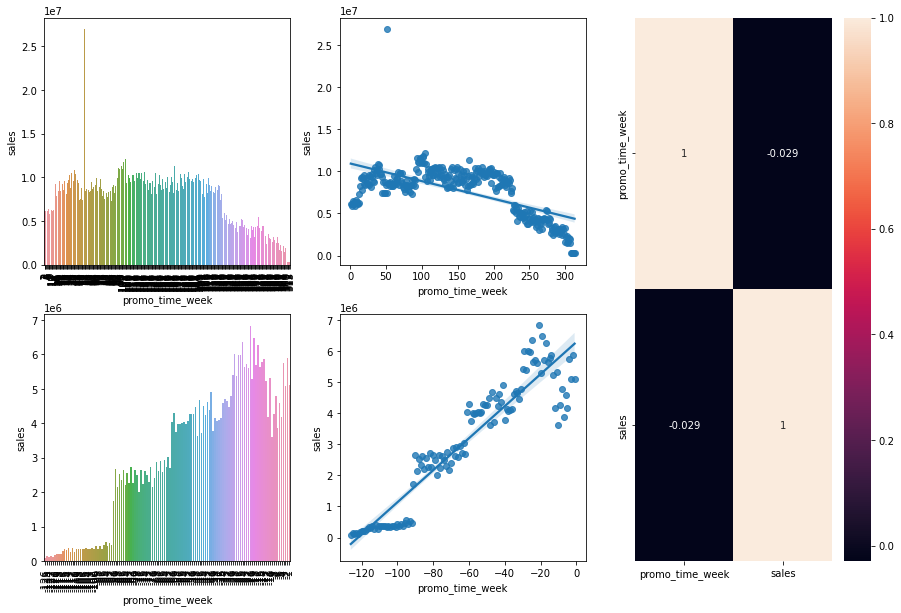

In [22]:
filter_h1 = df[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec(2, 3)

plt.figure(figsize=(15, 10))
plt.subplot(grid[0, 0])
extended = filter_h1[filter_h1['promo_time_week'] > 0]
sns.barplot(x='promo_time_week', y='sales', data=extended)
plt.xticks(rotation=90)

plt.subplot(grid[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=extended)


plt.subplot(grid[1, 0])
regular = filter_h1[filter_h1['promo_time_week'] < 0]
sns.barplot(x='promo_time_week', y='sales', data=regular)
plt.xticks(rotation=90);


plt.subplot(grid[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=regular)

plt.subplot(grid[:, 2])
sns.heatmap(filter_h1.corr(method='pearson'), annot=True);

### <s> H5. Lojas com mais dias de promoção vendem mais. <s>

### H6. Lojas com mais promoções consecutivas vendem mais.

**FALSA** Lojas com mais promocões consecutivas vendem menos.

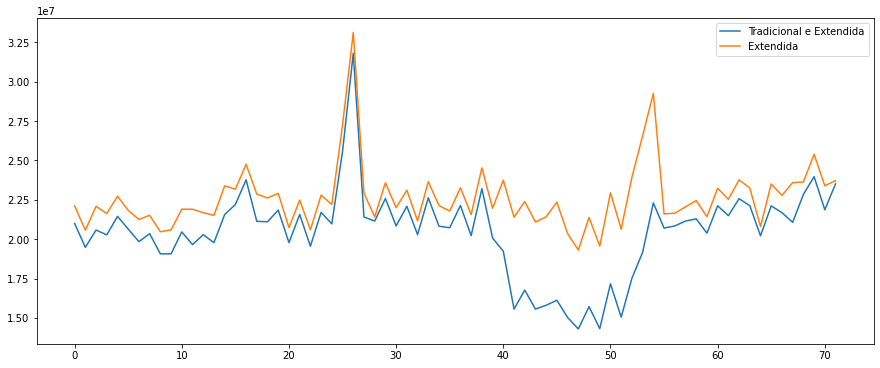

In [23]:
filter_1 = df[(df['promo'] == 1) & (df['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = filter_1.plot()

filter_2 = df[(df['promo'] == 1) & (df['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
filter_2.plot(ax=ax, figsize=(15, 6))

ax = plt.legend(labels=['Tradicional e Extendida', 'Extendida'])

### H7. Lojas abertas durante o feriado de Natal vendem mais.

**FALSA** Lojas abertas durante o feriado de Natal vendem menos.

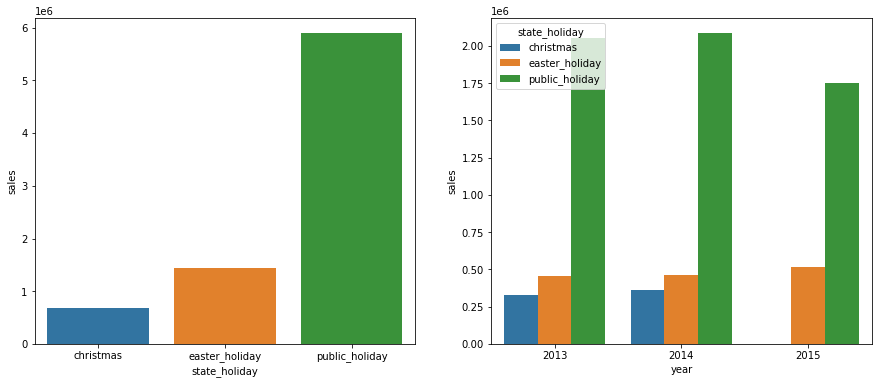

In [24]:
filter_1 = df[df['state_holiday'] != 'regular_day']
filter_h2 = filter_1[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='state_holiday', y='sales', data=filter_h2)

plt.subplot(1, 2, 2)
filter_3 = filter_1[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', data=filter_3, hue='state_holiday');

### H8. Lojas vendem mais ao longo dos anos.

**FALSA** Lojas vendem menos ao longo dos anos.

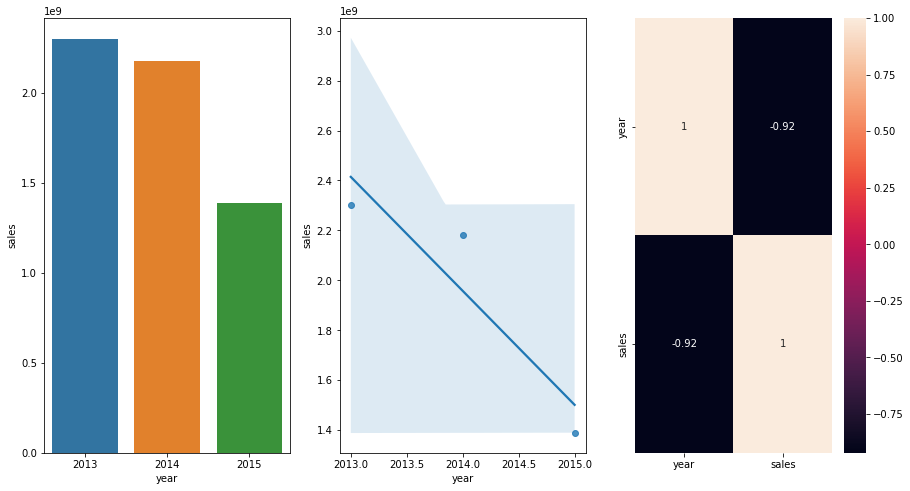

In [25]:
filter_h1 = df[['year', 'sales']].groupby('year').sum().reset_index()

plt.figure(figsize=(15, 8))
plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=filter_h1)

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=filter_h1)

plt.subplot(1, 3, 3)
sns.heatmap(filter_h1.corr(method='pearson'), annot=True);

### H9.Lojas vendem mais no segundo semestre do ano.

**FALSA** Lojas vendem menos no segundo semestre do ano.

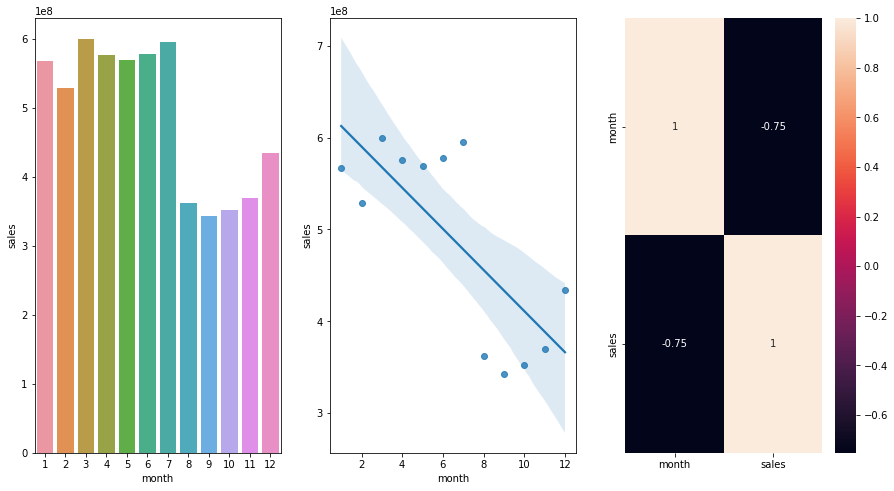

In [26]:
filter_h1 = df[['month', 'sales']].groupby('month').sum().reset_index()

plt.figure(figsize=(15, 8))
plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=filter_h1)

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=filter_h1)

plt.subplot(1, 3, 3)
sns.heatmap(filter_h1.corr(method='pearson'), annot=True);

### H10. Lojas vendem mais depois do dia 10 de cada mês.

**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mês.

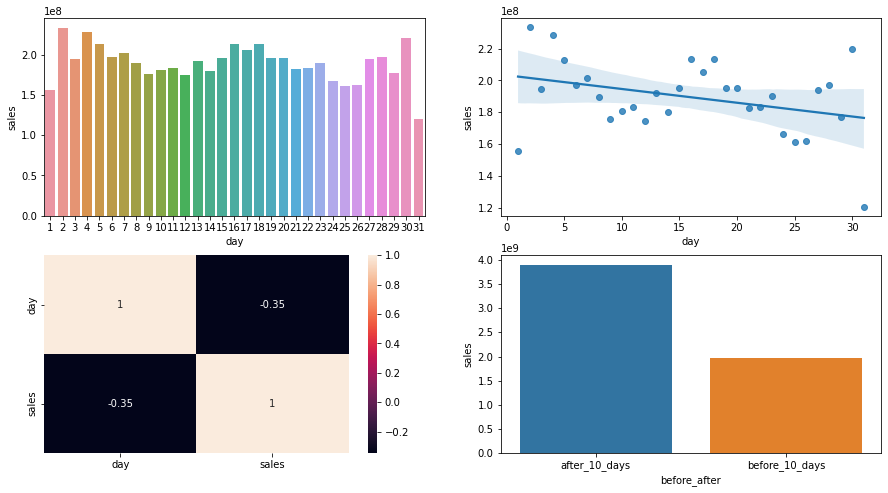

In [27]:
filter_h1 = df[['day', 'sales']].groupby('day').sum().reset_index()

plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=filter_h1)

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=filter_h1)

plt.subplot(2, 2, 3)
sns.heatmap(filter_h1.corr(method='pearson'), annot=True)

plt.subplot(2, 2, 4)
filter_h1['before_after'] = filter_h1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
filter_h2 = filter_h1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=filter_h2);

### H11. Lojas vendem menos aos finais de semana.

**VERDADEIRA** Lojas vendem menos aos finais de semana.

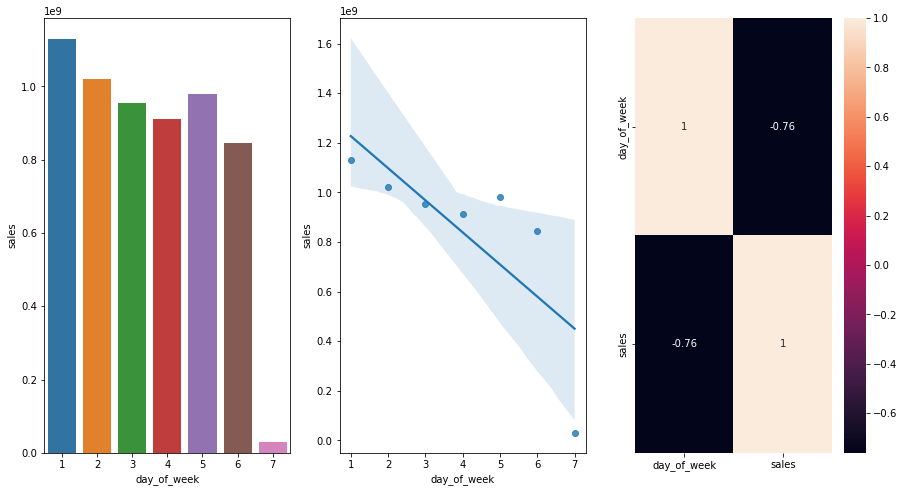

In [28]:
filter_h1 = df[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.figure(figsize=(15, 8))
plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=filter_h1)

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=filter_h1)

plt.subplot(1, 3, 3)
sns.heatmap(filter_h1.corr(method='pearson'), annot=True);

### H12. Lojas vendem menos durante os feriados escolares.

**VERDADEIRA** Lojas vendem menos durante os feriados escolares, exceto os meses de Julho e Agosto.

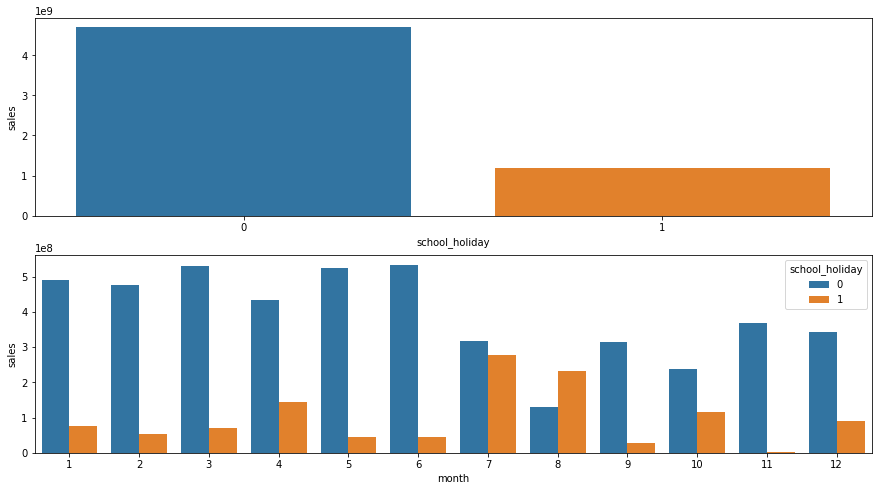

In [29]:
filter_h1 = df[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=filter_h1)

plt.subplot(2, 1, 2)
filter_h2 = df[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=filter_h2);

## 8.3 Análise Multivariada

### 8.3.1 Variável Numérica

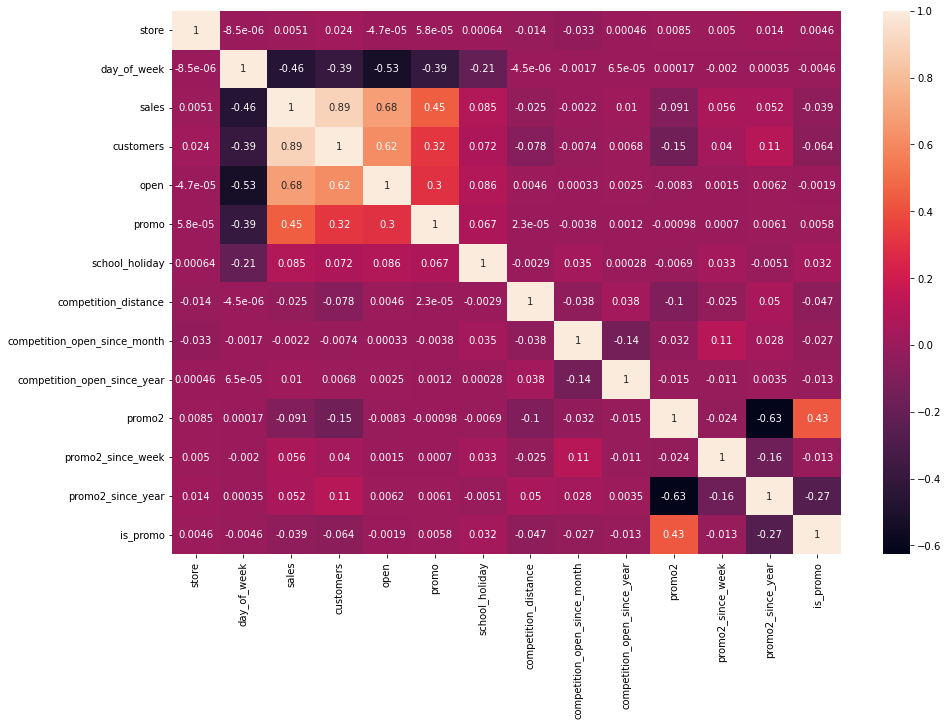

In [30]:
plt.figure(figsize=(15, 10))
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 8.3.2 Variável Categórica

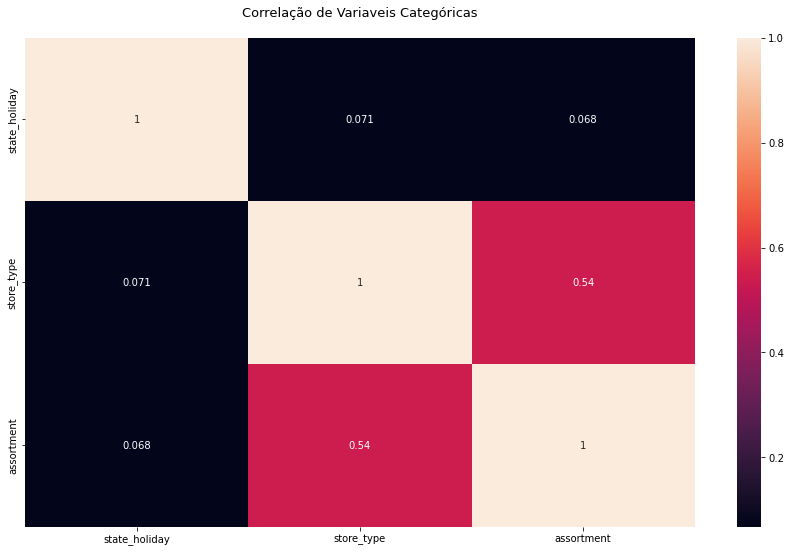

In [31]:
# Categorical data
categories = df[['state_holiday', 'store_type', 'assortment']]

# Apply correlation 
matrix = show_matrix(data=categories, col='state_holiday', output='dict')
data_columns = categories.iloc[:, 1:]

for c in data_columns.columns:
    matrix[c] = show_matrix(data=categories, col=c, output='list')

# Figure
plt.figure(figsize=(15, 9))
sns.heatmap(matrix, annot=True)
plt.title('Correlação de Variaveis Categóricas\n', fontsize=13);

# 9.0 PREPARAÇÃO DE DADOS

In [32]:
df2 = df.copy()

## 9.1 Rescaling

In [33]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df2['competition_distance'] = rs.fit_transform(df2[['competition_distance']].values)


# competition time month
df2['competition_time_month'] = rs.fit_transform(df2[['competition_time_month']].values)


# promo time week
df2['promo_time_week'] = mms.fit_transform(df2[['promo_time_week']].values)


# year
df2['year'] = mms.fit_transform(df2[['year']].values)

## 9.2 Transformação

### 9.2.1 Encoding

In [34]:
# state_holiday - One Hot Encoding
df2 = pd.get_dummies(df2, prefix=['state_holiday'], columns=['state_holiday'])


# store_type - Label Encoder
le = LabelEncoder()
df2['store_type'] = le.fit_transform(df2['store_type'])


# assortment - Ordinal Encoder
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df2['assortment'] = df2['assortment'].map(assortment_dict)

### 9.2.2 Transformação de Variável Resposta

In [35]:
df2['sales'] = np.log(df2['sales'])

### 9.2.3 Tranformação de Natureza

In [36]:
# day_of_week
df2['day_of_week_sin'] = df2['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi / 7)))
df2['day_of_week_cos'] = df2['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi / 7)))


# month
df2['month_sin'] = df2['month'].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
df2['month_cos'] = df2['month'].apply(lambda x: np.cos(x * (2. * np.pi / 12)))


# day
df2['day_sin'] = df2['day'].apply(lambda x: np.sin(x * (2. * np.pi / 30)))
df2['day_cos'] = df2['day'].apply(lambda x: np.cos(x * (2. * np.pi / 30)))


# week_of_year
df2['week_of_year_sin'] = df2['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi / 52)))
df2['week_of_year_cos'] = df2['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi / 52)))

# 10.0 SELEÇÃO DE FEATURE

In [37]:
df3 = df2.copy()

## 10.1 Divisão de Dados

In [38]:
cols_drop = ['week_of_year', 'day_of_week', 'day', 'month', 'promo_since', 'competition_since', 'year_week']

df3 = df3.drop(columns=cols_drop)

In [39]:
date_hour = df3[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)
    
date = str(date_hour)[:10]

# Training dataset
X_train = df3[df3['date'] < date]
Y_train = X_train['sales']

# Test dataset
X_test = df3[df3['date'] >= date]
Y_test = X_test['sales']

print(f"Training Min Date: {X_train['date'].min()}")
print(f"Training Max Date: {X_train['date'].max()}")

print(f"\nTest Min Date: {X_test['date'].min()}")
print(f"Test Min Date: {X_test['date'].max()}")

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Min Date: 2015-07-31 00:00:00


## 10.2 Boruta para Seleção de Feature

In [ ]:
# Training and test dataset for Boruta
X_train_n = X_train.drop(columns=['date', 'sales']).values
Y_train_n = Y_train.values.ravel()

# Define Random Forest
rf = RandomForestRegressor(n_jobs=1)

# Define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, Y_train_n)

### 10.2.1 Melhores Features do Boruta

In [ ]:
cols_selected = boruta.support_.tolist()

# Best Features
X_train_fs = X_train.drop(columns=['date', 'sales'])
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()


# Not Selected Boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

### 10.3 Manual Seleção de Feature

In [40]:
cols_selected_boruta = ['store', 'promo', 'store_type', 'assortment', 'competition_distance',
                        'competition_open_since_month', 'competition_open_since_year', 'promo2',
                        'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                        'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 
                        'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']

# Columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 11.0 MODELAGEM DE MACHINE LEARNING

In [41]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

x_training = X_train[cols_selected_boruta_full] 

## 11.1 Modelo de Média

In [42]:
aux1 = x_test.copy()
aux1['sales'] = Y_test.copy()

# Prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# Performance
baseline_result = ml_error('Average Model', np.expm1(Y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800167,0.206441,1835.141019


## 11.2 Modelo de Regressão Linear

In [43]:
# Model
lr = LinearRegression().fit(x_train, Y_train)

# Prediction
yhat_lr = lr.predict(x_test)

# Performance
lr_result = ml_error('Linear Regression', np.expm1(Y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.086951,0.292756,2671.056821


### 11.2.1 Regressão Linear - Cross Validation

In [44]:
lr_result_cv = cross_validation(x_training, kfold=5, model_name='Linear Regression', model=lr)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1995.05 +/- 45.55,0.3 +/- 0.01,2847.67 +/- 97.29


## 11.3 Modelo de Regressão Linear Regularizada - Lasso

In [45]:
# Model
lrr = Lasso(alpha=0.01).fit(x_train, Y_train)

# Prediction
yhat_lrr = lrr.predict(x_test)

# Performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(Y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.702084,0.289165,2744.462517


### 11.3.1 Regressão Linear Regularizada  Lasso - Cross Validation

In [46]:
lrr_result_cv = cross_validation(x_training, kfold=5, model_name='Lasso', model=lrr)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2035.93 +/- 60.74,0.29 +/- 0.0,2965.25 +/- 101.42


## 11.4 Random Forest Regressor

In [47]:
# Model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, Y_train)

# Prediction
yhat_rf = rf.predict(x_test)

# Performance
rf_result = ml_error('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.948666,0.099899,1010.055097


### 11.4.1 Random Forest - Cross Validation

In [ ]:
rf_result_cv = cross_validation(x_training, kfold=5, model_name='Random Forest', model=rf)
rf_result_cv

## 11.5 XGBoost Regressor

In [48]:
# Model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, Y_train)

# Prediction
yhat_xgb = model_xgb.predict(x_test)

# Performance
xgb_result = ml_error('RGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,RGBoost Regressor,6682.562768,0.949449,7329.916429


### 11.5.1 XGBoost Regressor - Cross Validation

In [49]:
xgb_result_cv = cross_validation(x_training, kfold=5, model_name='XGBoost', model=model_xgb)
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,6944.54 +/- 119.63,0.95 +/- 0.0,7596.86 +/- 138.9


## 11.6 Comparação de Performace dos Modelos

### 11.6.1 Performace

In [50]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])

modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.948666,0.099899,1010.055097
0,Average Model,1354.800167,0.206441,1835.141019
0,Linear Regression,1867.086951,0.292756,2671.056821
0,Linear Regression - Lasso,1891.702084,0.289165,2744.462517
0,RGBoost Regressor,6682.562768,0.949449,7329.916429


### 11.6.2 Performace Real - Cross Validation

In [51]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])

modelling_result_cv

NameError: name 'rf_result_cv' is not defined

# 12.0 AJUSTE DE HIPERPARAMETROS

## 12.1 Random Search

In [58]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
}

MAX_EVAL = 10

In [59]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    # choose values for parameters randomly
    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
    print(hp)
    
    # Model
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'],
                                 eta=hp['eta'],
                                 max_depth=hp['max_depth'],
                                 subsample=hp['subsample'],
                                 colsample_bytree=hp['colsample_bytree'],
                                min_child_weight=hp['min_child_weight'])


    # Performance
    result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb)
    final_result = pd.concat([final_result, result])
    
final_result

{'n_estimators': 25, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 17, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8}


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7337.55 +/- 50.62,1.0 +/- 0.0,7971.51 +/- 77.13
0,XGBoost Regressor,7301.64 +/- 50.64,0.99 +/- 0.0,7938.03 +/- 77.22


## 12.2 Modelo Final

In [61]:
param_tuned = {
    'n_estimators': 17,
    'eta': 0.03,
    'max_depth': 3,
    'subsample': 0.5,
    'colsample_bytree': 0.7,
    'min_child_weight': 8
}


# Model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=param_tuned['n_estimators'],
                                   eta=param_tuned['eta'],
                                   max_depth=param_tuned['max_depth'],
                                   subsample=param_tuned['subsample'],
                                   colsample_bytree=param_tuned['colsample_bytree'],
                                   min_child_weight=param_tuned['min_child_weight']).fit(x_train, Y_train)


# Prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# Performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6948.811818,0.992392,7585.776476
